In [1]:
%pylab nbagg

Populating the interactive namespace from numpy and matplotlib


Script based on simulate_bold_continuation tutorial 
see that script for more comments on the steps

In [2]:
from tvb.simulator.lab import *

# load libraries
import csv
import matplotlib.pyplot as plt
import multiprocessing as mp 
import numpy as np
import os
import pandas as pd
import scipy
import scipy.io as sio
import scipy.signal as sig
import scipy.stats as stat
import sys
import zipfile
from tvb.simulator.plot.tools import *
from tvb.simulator.lab import *
#from tvb.simulator.models.wong_wang_exc_io_inh_i import ReducedWongWangExcIOInhI
from tvb.datatypes.time_series import TimeSeriesRegion
from tvb.analyzers import fmri_balloon
import tvb.analyzers.correlation_coefficient as corr_coeff
LOG = get_logger('BrainTumor')

/mnt/c/Users/celie/OneDrive/Documenten/TVB_Distribution/tvb_data/lib/python2.7/site-packages/tvb/simulator/lab.py:46: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to u'nbAgg' by the following code:
  File "/mnt/c/Users/celie/OneDrive/Documenten/TVB_Distribution/tvb_data/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/mnt/c/Users/celie/OneDrive/Documenten/TVB_Distribution/tvb_data/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/mnt/c/Users/celie/OneDrive/Documenten/TVB_Distribution/tvb_data/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/mnt/c/Users/celie/OneDrive/Documenten/TVB_Distribution/tvb_data/lib/python2.7/site

   INFO  log level set to INFO


/mnt/c/Users/celie/OneDrive/Documenten/TVB_Distribution/tvb_data/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [3]:
oscilator = models.ReducedWongWang()

In [4]:
import os
os.getcwd()
os.chdir('/mnt/c/Users/celie/OneDrive/Documenten/TVB_Distribution/myData')

In [9]:

def load_connectivity(input_name):
    zip_file_name = input_name + zip_suffix + ".zip"
    dir_name = input_name + zip_suffix
    zip_path = data_dir + "/" + input_name + "/" + zip_file_name
    dir_path = data_dir + "/" + input_name + "/" + dir_name
    
    # Load the connectivity data
    conn = connectivity.Connectivity.from_file(zip_path)
    # Configure, to compute derived data, such as number_of_nodes and delays
    conn.configure()
    
    # Check weight matrix from .zip is corresponding to structural connectivity matrix from matlab file. 
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(dir_path)
    weight_txt = np.loadtxt(fname = dir_path + "/weights.txt")
    # Load the structural connectivity matrix from matlab file
    SC_path = data_dir + "/" + input_name + "/SCthrAn.mat"
    x = sio.loadmat(SC_path)
    assert(np.allclose(x['SCthrAn'], weight_txt), "Weight matrix in weights.txt should be the same as SCthrAn.mat")
    return conn

<ipython-input-9-c16f84b6d772>:20: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(np.allclose(x['SCthrAn'], weight_txt), "Weight matrix in weights.txt should be the same as SCthrAn.mat")


WARNING  File 'hemispheres' not found in ZIP.


/mnt/c/Users/celie/OneDrive/Documenten/TVB_Distribution/tvb_data/lib/python2.7/site-packages/tvb/basic/readers.py:125: UserWarning: loadtxt: Empty input file: "<zipfile.ZipExtFile object at 0x7fdebe22a090>"
  array_result = numpy.loadtxt(file_stream, dtype=dtype, skiprows=skip_rows, usecols=use_cols)


<IPython.core.display.Javascript object>


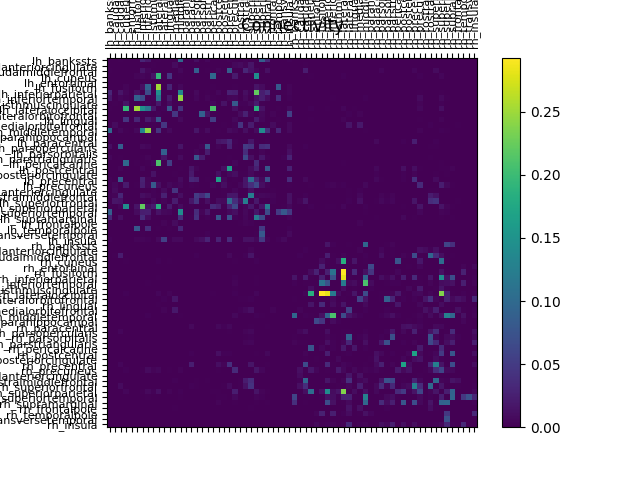

<IPython.core.display.Javascript object>


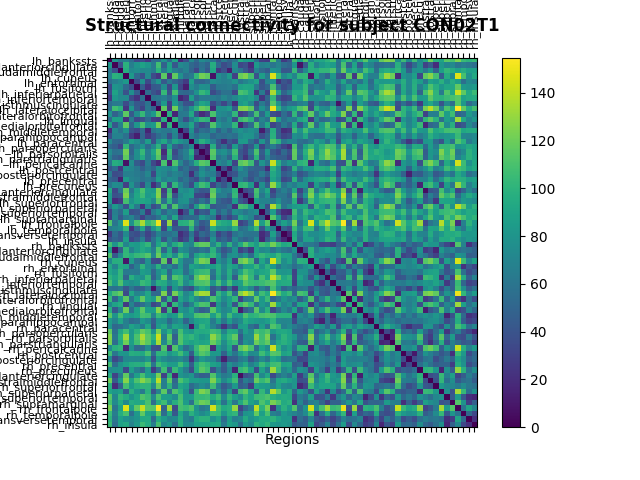

Text(0.5,1.05,u'Structural connectivity for subject CON02T1')

In [10]:
# Load the connectivity data
# Set input directory name follows "CONXXTX"
# Controls are the "CONxx", patients are "PATxx", before surgery is denoted with "T1", after surgery is "T2".
input_name = "CON02T1"
#conn = load_connectivity(input_name)
# Load the connectivity data
conn = connectivity.Connectivity.from_file("CON02T1_TVB.zip")
conn.configure()

# Show connectivity summary information.
conn.summary_info

# Plot Structural Connectivity Info: A 2D plot for visualizing the Connectivity.weights matrix
plot_connectivity(connectivity = conn, plot_tracts=True)
plt.xlabel("Regions")
plt.ylabel("Regions")
connectivity_title = "Structural connectivity for subject " + input_name
plt.title(connectivity_title, fontweight="bold", fontsize="12", y = 1.05)

In [11]:
sim = simulator.Simulator(
    model=oscilator, 
    connectivity=conn,                      
    coupling=coupling.Linear(),
    simulation_length=1e4,
    integrator=integrators.HeunStochastic(
        dt=2 ** -4,
        noise=noise.Additive(nsig=array([0.001]))),
    monitors=(
        monitors.TemporalAverage(period=1.0),
        monitors.Bold(period=500.0),
        monitors.ProgressLogger(period=1e3)
    )
).configure()

In [8]:
simulator.Simulator()

Parameter,Value,Description
initial_conditions,None,"Initial conditions from which the simulation will begin. By default, random initial conditions are provided. Needs to be the same shape as simulator 'history', ie, initial history function which defines the minimal initial state of the network with time delays before time t=0. If the number of time points in the provided array is insufficient the array will be padded with random values based on the 'state_variables_range' attribute."
coupling,"Linear(a=0.00390625, b=0)",The coupling function is applied to the activity propagated between regions by the ``Long-range connectivity`` before it enters the local dynamic equations of the Model. Its primary purpose is to 'rescale' the incoming activity to a level appropriate to Model.
stimulus,None,"A ``Spatiotemporal stimulus`` can be defined at the region or surface level. It's composed of spatial and temporal components. For region defined stimuli the spatial component is just the strength with which the temporal component is applied to each region. For surface defined stimuli, a (spatial) function, with finite-support, is used to define the strength of the stimuli on the surface centred around one or more focal points. In the current version of TVB, stimuli are applied to the first state variable of the ``Local dynamic model``."
integrator,HeunDeterministic(dt=0.012207),A tvb.simulator.Integrator object which is an integration scheme with supporting attributes such as integration step size and noise specification for stochastic methods. It is used to compute the time courses of the model state variables.
surface,None,"By default, a Cortex object which represents the cortical surface defined by points in the 3D physical space and their neighborhood relationship. In the current TVB version, when setting up a surface-based simulation, the option to configure the spatial spread of the ``Local Connectivity`` is available."
connectivity,None,"A tvb.datatypes.Connectivity object which contains the structural long-range connectivity data (i.e., white-matter tracts). In combination with the ``Long-range coupling function`` it defines the inter-regional connections. These couplings undergo a time delay via signal propagation with a propagation speed of ``Conduction Speed``"
conduction_speed,3.0,Conduction speed for ``Long-range connectivity`` (mm/ms)
simulation_length,1000.0,The length of a simulation (default in milliseconds).
model,"Generic2dOscillator(bound=False, value=None)","A tvb.simulator.Model object which describe the local dynamic equations, their parameters, and, to some extent, where connectivity (local and long-range) enters and which state-variables the Monitors monitor. By default the 'Generic2dOscillator' model is used. Read the Scientific documentation to learn more about this model."
monitors,"TemporalAverage(period=0.976562, voi=[])","A tvb.simulator.Monitor or a list of tvb.simulator.Monitor objects that 'know' how to record relevant data from the simulation. Two main types exist: 1) simple, spatial and temporal, reductions (subsets or averages); 2) physiological measurements, such as EEG, MEG and fMRI. By default the Model's specified variables_of_interest are returned, temporally downsampled from the raw integration rate to a sample rate of 1024Hz."


In [12]:
(tavg_time, tavg_data), (bold_time, bold_data), _ = sim.run()

   INFO  step 1 time 0.0001 s
   INFO  step 16001 time 1.0001 s
   INFO  step 32001 time 2.0001 s
   INFO  step 48001 time 3.0001 s
   INFO  step 64001 time 4.0001 s
   INFO  step 80001 time 5.0001 s
   INFO  step 96001 time 6.0001 s
   INFO  step 112001 time 7.0001 s
   INFO  step 128001 time 8.0001 s
   INFO  step 144001 time 9.0001 s


<IPython.core.display.Javascript object>


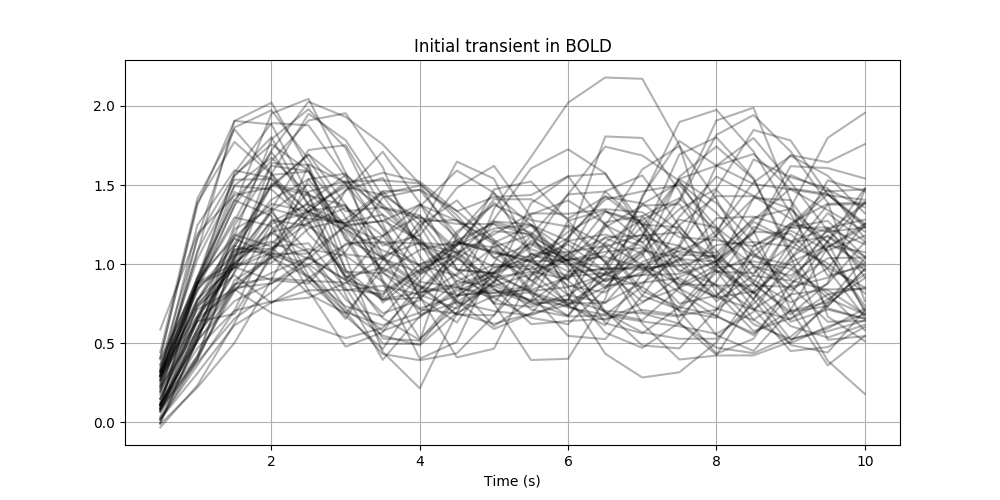

In [13]:
figure(figsize=(10, 5))
plot(bold_time * 1e-3, bold_data[:, 0, :, 0], 'k', alpha=0.3)
title('Initial transient in BOLD')
xlabel('Time (s)')
grid(True);

In [14]:
sim_state_fname = 'sim_state.pickle'

import cPickle
with open(sim_state_fname, 'wb') as file_descr:
    cPickle.dump({
        'history': sim.history.buffer,
        'current_step': sim.current_step,
        'current_state': sim.current_state,
        'bold_inner': sim.monitors[1]._interim_stock,
        'bold': sim.monitors[1]._stock,
        'rng': sim.integrator.noise.random_stream.get_state()
    }, file_descr)

In [15]:
!ls -lh sim_state.pickle

-rwxrwxrwx 1 celieni celieni 9.5M Mar 18 09:20 sim_state.pickle


In [16]:
del sim

In [18]:
sim = simulator.Simulator(
    model=oscilator, 
    connectivity=conn,                      
    coupling=coupling.Linear(),
    simulation_length=1e4,
    integrator=integrators.HeunStochastic(
        dt=2 ** -4,
        noise=noise.Additive(nsig=array([0.001]))),
    monitors=(
        monitors.TemporalAverage(period=1.0),
        monitors.Bold(period=500.0),
        monitors.ProgressLogger(period=1e3)
    )
).configure()

In [19]:
with open(sim_state_fname, 'rb') as file_descr:
    state = cPickle.load(file_descr)

sim.history.buffer = state['history']
sim.current_step = state['current_step']
sim.current_state = state['current_state']
sim.monitors[1]._interim_stock = state['bold_inner']
sim.monitors[1]._stock = state['bold']
sim.integrator.noise.random_stream.set_state(state['rng'])

In [20]:
(tavg_time, tavg_data), (bold_time, bold_data), _ = sim.run()

   INFO  step 160001 time 10.0001 s
   INFO  step 176001 time 11.0001 s
   INFO  step 192001 time 12.0001 s
   INFO  step 208001 time 13.0001 s
   INFO  step 224001 time 14.0001 s
   INFO  step 240001 time 15.0001 s
   INFO  step 256001 time 16.0001 s
   INFO  step 272001 time 17.0001 s
   INFO  step 288001 time 18.0001 s
   INFO  step 304001 time 19.0001 s


<IPython.core.display.Javascript object>


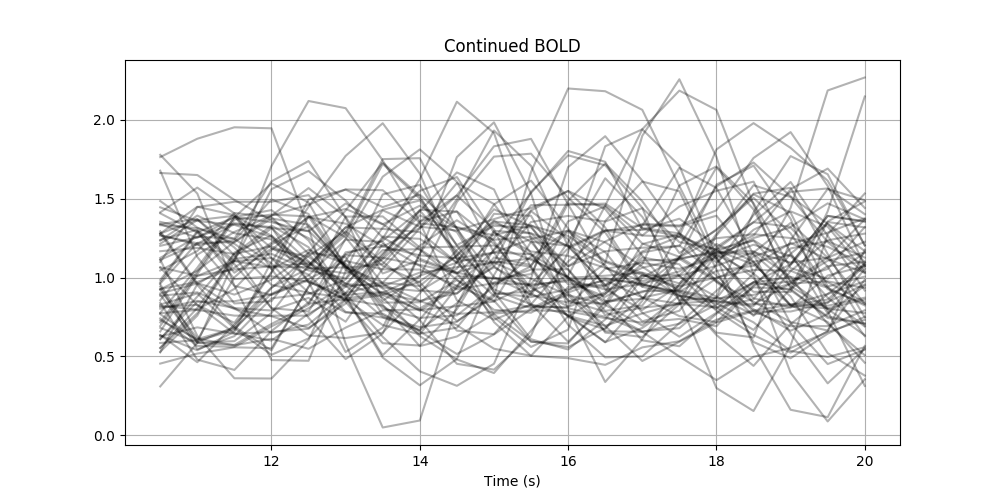

In [22]:
figure(figsize=(10, 5))
plot(bold_time * 1e-3, bold_data[:, 0, :, 0], 'k', alpha=0.3)
title('Continued BOLD')
xlabel('Time (s)')
grid(True);